In [1]:
# pip install networkx matplotlib numpy scipy pandas pulp reportlab uuid

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import logging
import heapq
import random
import os
import uuid

# We'll use PuLP for linear/mixed-integer linear programming
# If not installed, install via: pip install pulp
import pulp
from pulp import COIN_CMD  # or GLPK_CMD, if you prefer

# (Optional) For PDF export of tabular solution:
# pip install reportlab
try:
    from reportlab.lib.pagesizes import letter
    from reportlab.pdfgen import canvas
    from reportlab.lib.utils import ImageReader
    REPORTLAB_AVAILABLE = True
except ImportError:
    REPORTLAB_AVAILABLE = False

In [3]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [4]:
# ------------------------------------------------------------------------------------
# Node Class
# ------------------------------------------------------------------------------------
class Node:
    """
    A Node in our directed graph. It can contain:
    - An objective function
    - A solver
    - Whether the node is a constant (no optimization)
    - Constraints that apply to the node's data
    - A subnetwork (a nested Graph)
    - A data sample
    - A flag (is_fixed) to skip optimization
    - A node_type to distinguish e.g. Factory, Warehouse, Retailer, etc.
    """

    def __init__(self, 
                 id, 
                 name, 
                 node_type=None,
                 objective=None, 
                 solver=None, 
                 is_constant=False, 
                 constraints=None,
                 is_fixed=False):
        """
        :param id: Unique identifier for the node
        :param name: Human-readable name
        :param node_type: e.g. 'Factory', 'Warehouse', 'Retailer', 'Transport', etc.
        :param objective: A callable or any function representing the objective if the node is optimizing
        :param solver: A solver (subclass of Solver) attached specifically to this node
        :param is_constant: Boolean indicating whether the node simply passes its input forward unchanged
        :param constraints: A dictionary of constraints (name -> function) that must be satisfied
        :param is_fixed: If True, this node's variables should not be optimized (e.g., we keep them as is)
        """
        self.id = id
        self.name = name
        self.node_type = node_type
        self.objective = objective
        self.solver = solver
        self.is_constant = is_constant
        self.constraints = constraints if constraints else {}
        self.subnetwork = None
        self.data_sample = None
        self.is_fixed = is_fixed

    def evaluate(self, inputs):
        """
        Evaluate this node, possibly using its solver or objective.
        """
        if self.is_constant:
            logger.info(f"Node {self.id} is constant; returning inputs directly.")
            return inputs
        if self.solver:
            logger.info(f"Node {self.id} has a solver; running solve() from solver.")
            return self.solver.solve()
        if self.objective:
            logger.info(f"Node {self.id} has an objective function; evaluating the objective.")
            return self.objective(inputs)
        # Fallback: return inputs if nothing special is configured
        return inputs

    def apply_constraints(self, data):
        """
        Enforce constraints defined for this node.
        """
        if self.constraints:
            for constraint_name, constraint_func in self.constraints.items():
                if not constraint_func(data):
                    raise ValueError(f"Constraint {constraint_name} failed for node {self.id}")
        return data

    def add_subnetwork(self, graph):
        """
        Attach a subnetwork (Graph) to this node.
        """
        self.subnetwork = graph

In [5]:
# ------------------------------------------------------------------------------------
# Edge Class
# ------------------------------------------------------------------------------------
class Edge:
    """
    A directed edge in the graph.
    """

    def __init__(self, source, target, weight=1, transform=None):
        """
        :param source: Source node id
        :param target: Target node id
        :param weight: Weight/cost/importance of this edge
        :param transform: A callable that transforms data (optional)
        """
        self.source = source
        self.target = target
        self.weight = weight
        self.transform = transform if transform else lambda x: x

    def apply(self, data):
        """
        Apply the transform and weight to the passed data.
        """
        return self.transform(data) * self.weight


In [6]:
# ------------------------------------------------------------------------------------
# Graph Class
# ------------------------------------------------------------------------------------
class Graph:
    """
    A directed graph of Node and Edge objects. Can also have a global solver.
    """

    def __init__(self, solver=None):
        self.nodes = {}
        self.edges = []
        self.global_constraints = {}
        self.solver = solver  # Solver attached to the entire graph

    def add_node(self, node):
        if node.id in self.nodes:
            raise ValueError(f"Node with id {node.id} already exists in the graph.")
        self.nodes[node.id] = node

    def add_edge(self, edge):
        if edge.source not in self.nodes or edge.target not in self.nodes:
            raise ValueError(
                "Both source and target nodes must be in the graph before adding an edge."
            )
        self.edges.append(edge)

    def simulate(self, data):
        """
        Simple forward pass through edges. 
        In a more sophisticated scenario, you'd do a topological sort or BFS/DFS, 
        especially if the graph can have multiple layers/paths.
        """
        try:
            logger.info("Simulation started")
            for edge in self.edges:
                node_source = self.nodes[edge.source]
                node_target = self.nodes[edge.target]

                # Evaluate the source node
                out_data = node_source.evaluate(data)
                node_source.apply_constraints(out_data)

                # Apply edge transform
                transformed_data = edge.apply(out_data)

                # Evaluate the target node with the transformed data
                data = node_target.evaluate(transformed_data)
                node_target.apply_constraints(data)

            logger.info("Simulation completed")
            return data
        except Exception as e:
            logger.error(f"Error during simulation: {e}")
            raise

    def solve(self):
        """
        If a global solver is attached, use it.
        """
        if self.solver:
            logger.info("Graph-level solver found, attempting solve()...")
            return self.solver.solve()
        else:
            raise NotImplementedError("No solver attached to the graph.")

    def visualize(self, advanced=False, pdf_path=None):
        """
        Visualize the directed graph using networkx.
        
        :param advanced: If True, do color-coding or layered layouts
        :param pdf_path: If provided, save the figure as a PDF at this path
        """
        graph_nx = nx.DiGraph()
        for node_id, node in self.nodes.items():
            graph_nx.add_node(node_id, label=node.name, node_type=node.node_type)

        for edge in self.edges:
            graph_nx.add_edge(edge.source, edge.target)

        # Let's do a layered or spring layout
        pos = nx.spring_layout(graph_nx, seed=42)

        node_labels = nx.get_node_attributes(graph_nx, 'label')
        node_types = nx.get_node_attributes(graph_nx, 'node_type')

        if advanced:
            # Color nodes by type
            color_map = []
            for n in graph_nx.nodes():
                ntype = node_types.get(n, "Other")
                if ntype is None:
                    color_map.append("gray")
                elif "Factory" in ntype:
                    color_map.append("orange")
                elif "Warehouse" in ntype:
                    color_map.append("lightblue")
                elif "Retailer" in ntype:
                    color_map.append("green")
                else:
                    color_map.append("gray")
        else:
            # Simple color
            color_map = "lightgray"

        plt.figure(figsize=(8,6))
        nx.draw(
            graph_nx, 
            pos, 
            with_labels=True, 
            labels=node_labels, 
            node_color=color_map, 
            node_size=2000,
            arrowstyle='->',
            arrowsize=12
        )
        plt.title("Graph Visualization" + (" (Advanced)" if advanced else ""))

        if pdf_path:
            plt.savefig(pdf_path, format='pdf')
            logger.info(f"Graph saved as PDF to: {pdf_path}")
        plt.show()


In [7]:
# ------------------------------------------------------------------------------------
# Generic Solver Class
# ------------------------------------------------------------------------------------
class Solver:
    def __init__(self, graph):
        self.graph = graph

    def solve(self):
        raise NotImplementedError("This method should be implemented by subclasses.")


In [8]:
# ------------------------------------------------------------------------------------
# BFS Solver
# ------------------------------------------------------------------------------------
class BFSSolver(Solver):
    """
    A basic BFS solver that finds a path from start to goal in an unweighted sense.
    """

    def __init__(self, graph, start, goal):
        super().__init__(graph)
        self.start = start
        self.goal = goal

    def solve(self):
        logger.info("Running BFS algorithm")
        visited = set()
        queue = [(self.start, [self.start])]  # (current_node, path)

        while queue:
            current, path = queue.pop(0)
            if current == self.goal:
                logger.info(f"Found path with BFS: {path}")
                return path

            visited.add(current)
            # Enqueue neighbors
            for edge in [e for e in self.graph.edges if e.source == current]:
                neighbor = edge.target
                if neighbor not in visited:
                    queue.append((neighbor, path + [neighbor]))

        logger.info("No path found with BFS.")
        return None


In [9]:
# ------------------------------------------------------------------------------------
# Dijkstra Solver
# ------------------------------------------------------------------------------------
class DijkstraSolver(Solver):
    """
    A basic Dijkstra solver that finds the shortest weighted path from start to goal.
    """

    def __init__(self, graph, start, goal):
        super().__init__(graph)
        self.start = start
        self.goal = goal

    def solve(self):
        logger.info("Running Dijkstra algorithm")
        dist = {node_id: float('inf') for node_id in self.graph.nodes}
        dist[self.start] = 0
        visited = set()
        predecessor = {}

        while len(visited) < len(self.graph.nodes):
            # Pick the unvisited node with the smallest dist
            unvisited_nodes = [(n, dist[n]) for n in self.graph.nodes if n not in visited]
            if not unvisited_nodes:
                break
            current, current_dist = min(unvisited_nodes, key=lambda x: x[1])
            visited.add(current)

            if current == self.goal:
                # Reconstruct path
                path = [current]
                while current in predecessor:
                    current = predecessor[current]
                    path.append(current)
                path.reverse()
                logger.info(f"Dijkstra path: {path}, distance = {dist[self.goal]}")
                return path

            # Relax edges
            for edge in [e for e in self.graph.edges if e.source == current]:
                neighbor = edge.target
                if neighbor not in visited:
                    new_dist = dist[current] + edge.weight
                    if new_dist < dist[neighbor]:
                        dist[neighbor] = new_dist
                        predecessor[neighbor] = current

        # If we finish the while loop without returning, there's no path
        logger.info("No path found with Dijkstra.")
        return None

In [10]:
# ------------------------------------------------------------------------------------
# A* Solver (pathfinding)
# ------------------------------------------------------------------------------------
class AStarSolver(Solver):
    """
    An example pathfinding solver. 
    """

    def __init__(self, graph, start, goal):
        super().__init__(graph)
        self.start = start
        self.goal = goal

    def heuristic(self, current, goal):
        # Simple numeric heuristic if the nodes are numeric. Otherwise zero.
        try:
            return abs(int(goal) - int(current))
        except:
            return 0

    def solve(self):
        logger.info("Running A* algorithm")
        open_set = []
        heapq.heappush(open_set, (0, self.start))

        came_from = {}
        g_score = {node: float('inf') for node in self.graph.nodes}
        g_score[self.start] = 0

        while open_set:
            _, current = heapq.heappop(open_set)
            if current == self.goal:
                path = self.reconstruct_path(came_from, current)
                logger.info(f"Found path using A*: {path}")
                return path

            for edge in [e for e in self.graph.edges if e.source == current]:
                neighbor = edge.target
                tentative_g_score = g_score[current] + edge.weight
                if tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score = tentative_g_score + self.heuristic(neighbor, self.goal)
                    heapq.heappush(open_set, (f_score, neighbor))

        logger.info("No path found using A*.")
        return None

    def reconstruct_path(self, came_from, current):
        total_path = [current]
        while current in came_from:
            current = came_from[current]
            total_path.append(current)
        return total_path[::-1]


In [11]:
# ------------------------------------------------------------------------------------
# MCTS Solver (Monte Carlo Tree Search)
# ------------------------------------------------------------------------------------
class MCTSSolver(Solver):
    """
    Random exploration of the graph, attempting to find a path from start to goal.
    """
    def __init__(self, graph, start, goal, iterations=100):
        super().__init__(graph)
        self.start = start
        self.goal = goal
        self.iterations = iterations

    def solve(self):
        logger.info("Running MCTS solver.")
        best_path = None
        best_score = float('inf')

        for _ in range(self.iterations):
            # Do a random path from start to goal
            path = self._random_path()
            score = self._path_cost(path)
            if path and score < best_score:
                best_path = path
                best_score = score

        logger.info(f"MCTS best path: {best_path}, cost={best_score}")
        return best_path

    def _random_path(self):
        """
        Builds a random path from self.start to self.goal, if possible.
        """
        if self.start not in self.graph.nodes or self.goal not in self.graph.nodes:
            return None

        path = [self.start]
        current = self.start
        visited = set([current])

        # Keep extending until we (hopefully) reach self.goal or get stuck
        while current != self.goal:
            neighbors = [e.target for e in self.graph.edges if e.source == current]
            if not neighbors:
                return None  # No path extends from here
            next_node = random.choice(neighbors)
            path.append(next_node)
            visited.add(next_node)
            current = next_node

            # If we create a loop that keeps going, break out
            if len(path) > (2 * len(self.graph.nodes)):
                return None

        return path

    def _path_cost(self, path):
        if not path:
            return float('inf')
        cost = 0
        for i in range(len(path) - 1):
            s = path[i]
            t = path[i+1]
            # Find the matching edge in the graph
            edge = next((e for e in self.graph.edges if e.source == s and e.target == t), None)
            if edge is None:
                return float('inf')
            cost += edge.weight
        return cost



In [12]:
# ------------------------------------------------------------------------------------
# PuLP Solver for Supply Chain (or any LP/MILP)
# ------------------------------------------------------------------------------------
class PulpSolver:
    """
    A solver that sets up and solves a linear (or integer) program using PuLP.
    We can handle supply/demand, cost, capacities, etc.
    """

    def __init__(self, graph, problem_name="SupplyChainModel", objective_type="maximize", cbc_path=None):
        """
        :param graph: The Graph object containing nodes and edges
        :param problem_name: Name for the LP problem
        :param objective_type: "maximize" or "minimize"
        :param cbc_path: Explicit path to the CBC solver, if needed (useful on certain systems)
        """
        self.graph = graph
        self.problem_name = problem_name
        self.objective_type = objective_type.lower()
        self.cbc_path = cbc_path  # path to cbc if needed
        self.model = None         # Will store the pulp.LpProblem
        self.flow_vars = {}       # Dictionary to store PuLP variables (edge -> variable)

    def build_problem(self, supply_df, demand_df, cost_df, capacity_df=None):
        """
        Build the LP problem from supply, demand, cost, and optional capacity DataFrames.

        :param supply_df:  pd.DataFrame with columns ["Node", "Supply"]
        :param demand_df:  pd.DataFrame with columns ["Node", "Demand"]
        :param cost_df:    pd.DataFrame with columns ["Source", "Target", "UnitCost"]
                           Optional: "Profit" column
        :param capacity_df: (Optional) pd.DataFrame with columns ["Source", "Target", "Capacity"]
        """
        logger.info(f"Building PuLP problem: {self.problem_name}")

        # Create PuLP problem
        if self.objective_type == "maximize":
            self.model = pulp.LpProblem(self.problem_name, pulp.LpMaximize)
        else:
            self.model = pulp.LpProblem(self.problem_name, pulp.LpMinimize)

        # Create decision variables for each edge
        logger.info("Creating decision variables for edges...")
        for edge in self.graph.edges:
            var_name = f"flow_{edge.source}_{edge.target}"
            if self.graph.nodes[edge.source].is_fixed:
                # If the source node is fixed, we set flow to 0 as an example
                self.flow_vars[(edge.source, edge.target)] = pulp.LpVariable(
                    var_name, lowBound=0, upBound=0, cat=pulp.LpContinuous
                )
            else:
                self.flow_vars[(edge.source, edge.target)] = pulp.LpVariable(
                    var_name, lowBound=0, cat=pulp.LpContinuous
                )

        # Build objective
        # If "Profit" column is missing, create a synthetic one (e.g., profit = 0.1 * cost)
        if "Profit" not in cost_df.columns:
            cost_df["Profit"] = cost_df["UnitCost"] * 0.1

        logger.info("Building objective function (Profit - Cost).")
        objective_expr = []
        for _, row in cost_df.iterrows():
            src, tgt = row["Source"], row["Target"]
            unit_cost = row["UnitCost"]
            unit_profit = row["Profit"]
            net_gain = unit_profit - unit_cost  # (Profit - Cost)
            if (src, tgt) in self.flow_vars:
                flow_var = self.flow_vars[(src, tgt)]
                objective_expr.append(net_gain * flow_var)

        # Add the objective expression to the model
        self.model += pulp.lpSum(objective_expr), "NetProfitMinusCost"

        # Supply constraints
        logger.info("Adding supply constraints.")
        for _, row in supply_df.iterrows():
            node_id = row["Node"]
            node_supply = row["Supply"]
            outgoing_edges = [(s, t) for (s, t) in self.flow_vars.keys() if s == node_id]
            if outgoing_edges:
                constraint_expr = pulp.lpSum([self.flow_vars[e] for e in outgoing_edges])
                self.model += (constraint_expr <= node_supply, f"Supply_{node_id}")

        # Demand constraints
        logger.info("Adding demand constraints.")
        for _, row in demand_df.iterrows():
            node_id = row["Node"]
            node_demand = row["Demand"]
            incoming_edges = [(s, t) for (s, t) in self.flow_vars.keys() if t == node_id]
            if incoming_edges:
                constraint_expr = pulp.lpSum([self.flow_vars[e] for e in incoming_edges])
                self.model += (constraint_expr >= node_demand, f"Demand_{node_id}")

        # Capacity constraints (optional)
        if capacity_df is not None:
            logger.info("Adding capacity constraints.")
            for _, row in capacity_df.iterrows():
                src, tgt = row["Source"], row["Target"]
                cap = row["Capacity"]
                if (src, tgt) in self.flow_vars:
                    self.model += (self.flow_vars[(src, tgt)] <= cap, f"Cap_{src}_{tgt}")

        logger.info("PuLP problem built successfully.")

    def solve(self):
        """
        Solve the PuLP problem once built.
        :return: dict with keys { "status", "objective_value", "solution" }
        """
        if not self.model:
            raise ValueError("No PuLP model has been built yet. Call build_problem() first.")

        logger.info(f"Solving PuLP model: {self.problem_name}")

        # If user provided a CBC path, use that solver with msg=1 (verbose)
        if self.cbc_path:
            solver = COIN_CMD(path=self.cbc_path, msg=1)
            self.model.solve(solver)
        else:
            # Use default solver
            self.model.solve()

        status = pulp.LpStatus[self.model.status]
        logger.info(f"Solve status: {status}")

        # Collect solution
        solution = {}
        for var_key, var_obj in self.flow_vars.items():
            solution[var_key] = pulp.value(var_obj)

        # Objective value
        obj_value = pulp.value(self.model.objective)
        logger.info(f"Objective value: {obj_value}")

        return {
            "status": status,
            "objective_value": obj_value,
            "solution": solution
        }

In [13]:
# ------------------------------------------------------------------------------------
# Utility for PDF Export (Optional)
# ------------------------------------------------------------------------------------
def export_solution_to_pdf(solution_dict, pdf_file="solution_report.pdf", title="Supply Chain Results"):
    """
    Exports a dictionary-based solution (e.g. from PuLP) to a PDF using ReportLab.

    :param solution_dict: dict with 'status', 'objective_value', 'solution'
    :param pdf_file: Output PDF file path
    :param title: Title for the PDF document
    """
    if not REPORTLAB_AVAILABLE:
        raise ImportError("ReportLab is not installed. Install via `pip install reportlab`.")

    c = canvas.Canvas(pdf_file, pagesize=letter)
    width, height = letter

    y_pos = height - 50
    c.setFont("Helvetica-Bold", 16)
    c.drawString(50, y_pos, title)
    y_pos -= 40

    c.setFont("Helvetica", 12)
    c.drawString(50, y_pos, f"Status: {solution_dict.get('status', 'Unknown')}")
    y_pos -= 20
    c.drawString(50, y_pos, f"Objective Value: {solution_dict.get('objective_value', 0.0)}")
    y_pos -= 30

    c.setFont("Helvetica-Bold", 12)
    c.drawString(50, y_pos, "Flows:")
    y_pos -= 20
    c.setFont("Helvetica", 12)

    for var_key, val in solution_dict.get("solution", {}).items():
        text_line = f"{var_key}: {round(val, 2)}"
        c.drawString(70, y_pos, text_line)
        y_pos -= 15
        if y_pos < 50:
            c.showPage()
            y_pos = height - 50
            c.setFont("Helvetica", 12)

    c.showPage()
    c.save()
    logger.info(f"Exported solution to PDF: {pdf_file}")


def export_solution_with_graph_to_pdf(solution_dict, graph, pdf_file="solution_report.pdf",
                                      title="Supply Chain Results",
                                      layout="spring", show_edge_labels=True,
                                      node_size=2000, edge_label_attr=None):
    """
    Exports:
      1. The solution status, objective, and flows (as text).
      2. A visualization of the network (with chosen layout & edge labeling).
    into a single PDF file.

    :param solution_dict: dict with keys:
                          { "status", "objective_value", "solution" }
    :param graph:         Your custom Graph object, containing nodes & edges.
    :param pdf_file:      Path to the final PDF.
    :param title:         Title to display in the PDF.
    :param layout:        One of ["spring", "circular", "shell", "kamada_kawai", "planar"].
                          Controls how we space out the graph in the figure.
    :param show_edge_labels: If True, label edges in the visualization.
    :param node_size:     Size of the nodes in the plot.
    :param edge_label_attr: If you want the edge labels to show a specific attribute (e.g. cost, capacity).
                            This function expects you to store that attribute in a dictionary or the Edge object.
                            If None, it draws a default label (the weight).
    """
    # 1) Construct a networkx DiGraph from your custom Graph
    G = nx.DiGraph()
    for node_id, node_obj in graph.nodes.items():
        # We'll store the node type in attributes, just in case
        G.add_node(node_id, label=node_obj.name, node_type=node_obj.node_type)

    # Optionally store some edge attribute (like cost, capacity). Suppose you do so in your code.
    # For demonstration, let's just store the 'weight' as Nx edge data, or you can store more.
    for edge_obj in graph.edges:
        # We'll attach 'weight' as a label, but you could do cost/capacity/etc.
        G.add_edge(edge_obj.source, edge_obj.target, weight=edge_obj.weight)

    # 2) Choose a layout
    if layout == "spring":
        pos = nx.spring_layout(G, seed=42, k=1.0)  # k controls spacing
    elif layout == "circular":
        pos = nx.circular_layout(G)
    elif layout == "shell":
        pos = nx.shell_layout(G)
    elif layout == "kamada_kawai":
        pos = nx.kamada_kawai_layout(G)
    elif layout == "planar":
        try:
            pos = nx.planar_layout(G)
        except nx.NetworkXException:
            # fallback if the graph is not planar
            pos = nx.spring_layout(G, seed=42)
            logger.warning("Graph not planar; falling back to spring_layout.")
    else:
        # default
        pos = nx.spring_layout(G, seed=42)

    # 3) Create a matplotlib figure
    plt.figure(figsize=(10, 7))
    
    # For color-coding by node type, do something like:
    node_colors = []
    for n in G.nodes():
        ntype = G.nodes[n].get("node_type", "")
        if "Factory" in ntype:
            node_colors.append("orange")
        elif "DC" in ntype:
            node_colors.append("yellow")
        elif "Warehouse" in ntype:
            node_colors.append("lightblue")
        elif "Retailer" in ntype:
            node_colors.append("green")
        else:
            node_colors.append("gray")

    labels_dict = nx.get_node_attributes(G, 'label')  # For node labels

    # Draw the graph
    nx.draw(G, pos, with_labels=True, labels=labels_dict,
            node_color=node_colors, node_size=node_size,
            arrowstyle='->', arrowsize=12)

    if show_edge_labels:
        # We'll either show 'weight' or the user-specified attribute
        edge_labels = {}
        if edge_label_attr is None:
            # use the "weight" attribute from G
            edge_labels = {(u, v): round(d['weight'], 2) for u, v, d in G.edges(data=True)}
        else:
            # if you had a custom attribute, e.g., capacity or cost
            # you'd do something like: edge_labels = {(u, v): d[edge_label_attr]} 
            # but you need to store that attribute in the edge first
            # For demonstration:
            edge_labels = {}
            for (u, v, d) in G.edges(data=True):
                val = d.get(edge_label_attr, d.get("weight", 0))
                edge_labels[(u, v)] = round(val, 2)

        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title("Supply Chain Graph")
    
    # Save the figure as a temporary PNG
    tmp_img_name = f"temp_graph_{uuid.uuid4()}.png"
    plt.savefig(tmp_img_name, format='png', dpi=150)
    plt.close()  # Close the matplotlib figure so we don't display inline

    # 4) Create the PDF using ReportLab
    c = canvas.Canvas(pdf_file, pagesize=letter)
    width, height = letter

    # Write the text info at the top
    y_pos = height - 50
    c.setFont("Helvetica-Bold", 16)
    c.drawString(50, y_pos, title)
    y_pos -= 40

    c.setFont("Helvetica", 12)
    c.drawString(50, y_pos, f"Status: {solution_dict.get('status', 'Unknown')}")
    y_pos -= 20
    c.drawString(50, y_pos, f"Objective Value: {solution_dict.get('objective_value', 0.0)}")
    y_pos -= 30

    c.setFont("Helvetica-Bold", 12)
    c.drawString(50, y_pos, "Flows:")
    y_pos -= 20
    c.setFont("Helvetica", 12)

    # List flows
    for var_key, val in solution_dict.get("solution", {}).items():
        text_line = f"{var_key}: {round(val,2)}"
        c.drawString(70, y_pos, text_line)
        y_pos -= 15
        if y_pos < 100:  # if we approach page bottom, show a new page
            c.showPage()
            y_pos = height - 50
            c.setFont("Helvetica", 12)

    # 5) Insert the graph image on a new page (or the same page if there's space).
    c.showPage()  # start a fresh page for the image
    img_reader = ImageReader(tmp_img_name)
    img_width, img_height = img_reader.getSize()

    # We'll scale the image to fit within the letter page margins
    max_width = width - 100
    max_height = height - 100
    scale = min(max_width / img_width, max_height / img_height)

    display_width = img_width * scale
    display_height = img_height * scale

    # Draw the image roughly centered
    x_offset = (width - display_width) / 2
    y_offset = (height - display_height) / 2

    c.drawImage(img_reader, x_offset, y_offset, display_width, display_height)

    c.showPage()
    c.save()

    # Optionally remove the temp image
    if os.path.exists(tmp_img_name):
        os.remove(tmp_img_name)

    logger.info(f"Exported solution and graph to PDF: {pdf_file}")


In [15]:
def compute_path_cost(graph, path):
    """
    Helper function to compute the sum of edge weights along a given path
    in our custom Graph structure.
    """
    if not path or len(path) < 2:
        return None
    total_cost = 0
    for i in range(len(path) - 1):
        s = path[i]
        t = path[i+1]
        # Find the corresponding edge in the graph
        edge = next((e for e in graph.edges if e.source == s and e.target == t), None)
        if edge is None:
            return None  # or float('inf')
        total_cost += edge.weight
    return total_cost

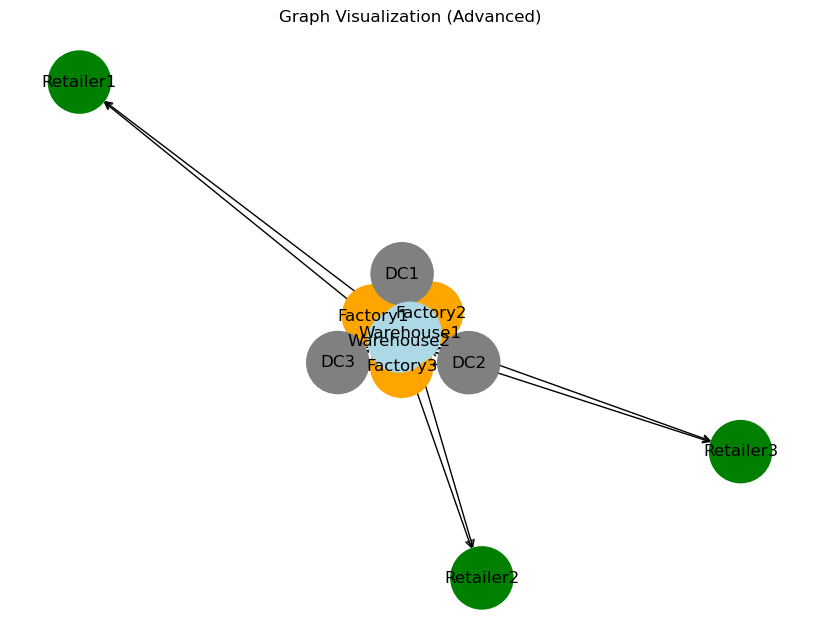

2025-01-20 17:16:58,764 - INFO - Running BFS algorithm
2025-01-20 17:16:58,764 - INFO - Found path with BFS: ['Factory1', 'DC1', 'W1', 'Retailer3']
2025-01-20 17:16:58,764 - INFO - Running Dijkstra algorithm
2025-01-20 17:16:58,764 - INFO - Dijkstra path: ['Factory1', 'DC1', 'W1', 'Retailer3'], distance = 5.5
2025-01-20 17:16:58,765 - INFO - Running A* algorithm
2025-01-20 17:16:58,765 - INFO - Found path using A*: ['Factory1', 'DC1', 'W1', 'Retailer3']
2025-01-20 17:16:58,765 - INFO - Running MCTS solver.
2025-01-20 17:16:58,766 - INFO - MCTS best path: ['Factory1', 'DC1', 'W1', 'Retailer3'], cost=5.5
2025-01-20 17:16:58,767 - INFO - Building PuLP problem: ComplexMultiEchelonSC
2025-01-20 17:16:58,768 - INFO - Creating decision variables for edges...
2025-01-20 17:16:58,768 - INFO - Building objective function (Profit - Cost).
2025-01-20 17:16:58,769 - INFO - Adding supply constraints.
2025-01-20 17:16:58,769 - INFO - Adding demand constraints.
2025-01-20 17:16:58,769 - INFO - Adding 

=== Pathfinding Results ===
  Solver                           Path  Cost
     BFS [Factory1, DC1, W1, Retailer3]   5.5
Dijkstra [Factory1, DC1, W1, Retailer3]   5.5
      A* [Factory1, DC1, W1, Retailer3]   5.5
    MCTS [Factory1, DC1, W1, Retailer3]   5.5
Welcome to the CBC MILP Solver 
Version: 2.10.12 
Build Date: Aug 20 2024 

command line - /opt/homebrew/bin/cbc /var/folders/f1/vk688s3j4fd2np_1sp2jpvxh0000gn/T/115e9673d2c048e28ba767d258cb6eb1-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/f1/vk688s3j4fd2np_1sp2jpvxh0000gn/T/115e9673d2c048e28ba767d258cb6eb1-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 19 COLUMNS
At line 64 RHS
At line 79 BOUNDS
At line 80 ENDATA
Problem MODEL has 14 rows, 21 columns and 23 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve thinks problem is unbounded
Analysis indicates model infeasible or unbounded
0  Obj -0 Primal inf 430 (

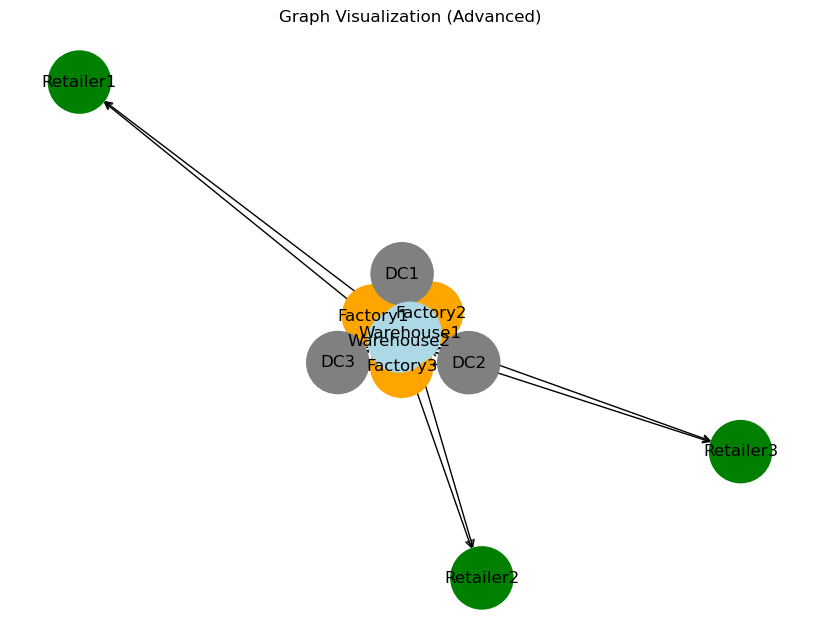

2025-01-20 17:16:59,281 - INFO - Exported solution and graph to PDF: complex_supply_chain_solution_with_graph.pdf


In [16]:
# ------------------------------------------------------------------------------------
# Main Demonstration
# ------------------------------------------------------------------------------------
if __name__ == "__main__":
    """
    We'll build a larger, more complex multi-echelon supply chain with:
      - 3 Factories (Factory1, Factory2, Factory3)
      - 3 Distribution Centers (DC1, DC2, DC3)
      - 2 Warehouses (W1, W2)
      - 3 Retailers (Retailer1, Retailer2, Retailer3)

    We'll demonstrate:
      1) BFS, Dijkstra, A*, MCTS pathfinding from Factory1 -> Retailer3 (compare them).
      2) PuLP optimization with supply/demand/cost/capacities in a larger network.
    """

    # ------------------------------------------------------------------------------
    # Step 1: Build a more complicated Graph
    # ------------------------------------------------------------------------------
    big_graph = Graph()

    # Add nodes: Factories
    big_graph.add_node(Node("Factory1",  "Factory1",  node_type="Factory"))
    big_graph.add_node(Node("Factory2",  "Factory2",  node_type="Factory"))
    big_graph.add_node(Node("Factory3",  "Factory3",  node_type="Factory"))
    # Distribution Centers
    big_graph.add_node(Node("DC1",       "DC1",       node_type="DC"))
    big_graph.add_node(Node("DC2",       "DC2",       node_type="DC"))
    big_graph.add_node(Node("DC3",       "DC3",       node_type="DC"))
    # Warehouses
    big_graph.add_node(Node("W1",        "Warehouse1",node_type="Warehouse"))
    big_graph.add_node(Node("W2",        "Warehouse2",node_type="Warehouse"))
    # Retailers
    big_graph.add_node(Node("Retailer1", "Retailer1", node_type="Retailer"))
    big_graph.add_node(Node("Retailer2", "Retailer2", node_type="Retailer"))
    big_graph.add_node(Node("Retailer3", "Retailer3", node_type="Retailer"))

    # -------------------------------
    # Add Edges (with "random-ish" weights)
    # Factories -> DC
    big_graph.add_edge(Edge("Factory1", "DC1", weight=2))
    big_graph.add_edge(Edge("Factory1", "DC2", weight=3))
    big_graph.add_edge(Edge("Factory1", "DC3", weight=4))

    big_graph.add_edge(Edge("Factory2", "DC1", weight=2.5))
    big_graph.add_edge(Edge("Factory2", "DC2", weight=4))
    big_graph.add_edge(Edge("Factory2", "DC3", weight=3))

    big_graph.add_edge(Edge("Factory3", "DC1", weight=3))
    big_graph.add_edge(Edge("Factory3", "DC2", weight=2.5))
    big_graph.add_edge(Edge("Factory3", "DC3", weight=3.5))

    # DC -> Warehouses
    big_graph.add_edge(Edge("DC1", "W1", weight=1))
    big_graph.add_edge(Edge("DC1", "W2", weight=1.2))
    big_graph.add_edge(Edge("DC2", "W1", weight=1.5))
    big_graph.add_edge(Edge("DC2", "W2", weight=2))
    big_graph.add_edge(Edge("DC3", "W1", weight=1.8))
    big_graph.add_edge(Edge("DC3", "W2", weight=2.2))

    # Warehouses -> Retailers
    big_graph.add_edge(Edge("W1", "Retailer1", weight=2))
    big_graph.add_edge(Edge("W1", "Retailer2", weight=3))
    big_graph.add_edge(Edge("W1", "Retailer3", weight=2.5))

    big_graph.add_edge(Edge("W2", "Retailer1", weight=2.2))
    big_graph.add_edge(Edge("W2", "Retailer2", weight=1.8))
    big_graph.add_edge(Edge("W2", "Retailer3", weight=3))

    # Visualize the multi-echelon graph in advanced mode
    big_graph.visualize(advanced=True)

    # ------------------------------------------------------------------------------
    # Step 2: Pathfinding with BFS, Dijkstra, A*, and MCTS
    # ------------------------------------------------------------------------------
    # We'll demonstrate a path from Factory1 to Retailer3
    start_node = "Factory1"
    goal_node = "Retailer3"

    # BFS
    bfs_solver = BFSSolver(graph=big_graph, start=start_node, goal=goal_node)
    bfs_path = bfs_solver.solve()
    bfs_cost = compute_path_cost(big_graph, bfs_path)

    # Dijkstra
    dijkstra_solver = DijkstraSolver(graph=big_graph, start=start_node, goal=goal_node)
    dijkstra_path = dijkstra_solver.solve()
    dijkstra_cost = compute_path_cost(big_graph, dijkstra_path)

    # A*
    a_star_solver = AStarSolver(graph=big_graph, start=start_node, goal=goal_node)
    a_star_path = a_star_solver.solve()
    a_star_cost = compute_path_cost(big_graph, a_star_path)

    # MCTS
    mcts_solver = MCTSSolver(graph=big_graph, start=start_node, goal=goal_node, iterations=200)
    mcts_path = mcts_solver.solve()
    mcts_cost = compute_path_cost(big_graph, mcts_path)

    # Print each solver's results
    path_results = [
        {"Solver": "BFS",       "Path": bfs_path,       "Cost": bfs_cost},
        {"Solver": "Dijkstra",  "Path": dijkstra_path,  "Cost": dijkstra_cost},
        {"Solver": "A*",        "Path": a_star_path,    "Cost": a_star_cost},
        {"Solver": "MCTS",      "Path": mcts_path,      "Cost": mcts_cost},
    ]
    df_paths = pd.DataFrame(path_results)
    print("=== Pathfinding Results ===")
    print(df_paths.to_string(index=False))

    # ------------------------------------------------------------------------------
    # Step 3: PuLP Optimization with supply/demand/cost/optional capacity
    # ------------------------------------------------------------------------------
    # We'll define supply for the 3 factories, and demand for the 3 retailers.
    # Edge cost data is derived from the same "weight" or something slightly different.
    supply_df = pd.DataFrame({
        "Node": ["Factory1", "Factory2", "Factory3"],
        "Supply": [200, 150, 180]  # total supply ~530
    })

    demand_df = pd.DataFrame({
        "Node": ["Retailer1", "Retailer2", "Retailer3"],
        "Demand": [120, 140, 170]  # total demand = 430
    })

    # Build cost data from the edges above; if you want a different mapping
    # (e.g. cost != weight), adapt accordingly.
    cost_list = []
    for e in big_graph.edges:
        cost_list.append({
            "Source": e.source,
            "Target": e.target,
            "UnitCost": e.weight,
            "Profit": e.weight * 1.2  # or something arbitrary
        })
    cost_df = pd.DataFrame(cost_list)

    # Optional capacities
    # We'll place capacity constraints on some Factory->DC lanes and DC->W
    capacity_list = [
        # Factories->DC (some random picks)
        {"Source": "Factory1", "Target": "DC1", "Capacity": 120},
        {"Source": "Factory1", "Target": "DC2", "Capacity": 100},
        {"Source": "Factory2", "Target": "DC3", "Capacity": 100},
        {"Source": "Factory3", "Target": "DC2", "Capacity": 130},

        # DC->W
        {"Source": "DC1", "Target": "W1", "Capacity": 150},
        {"Source": "DC1", "Target": "W2", "Capacity": 120},
        {"Source": "DC2", "Target": "W1", "Capacity": 90},
        {"Source": "DC3", "Target": "W2", "Capacity": 100},
    ]
    capacity_df = pd.DataFrame(capacity_list)

    # (Optional) If you want to fix flows from a node, e.g., Factory3 to zero, you can do:
    # big_graph.nodes["Factory3"].is_fixed = True

    # Attach a PuLPSolver to the graph
    pulp_solver = PulpSolver(
        graph=big_graph,
        problem_name="ComplexMultiEchelonSC",
        objective_type="maximize",
        cbc_path="/opt/homebrew/bin/cbc"  # or None if default solver is OK
    )
    big_graph.solver = pulp_solver

    # Build the LP model with supply/demand/cost/capacity
    pulp_solver.build_problem(supply_df, demand_df, cost_df, capacity_df=capacity_df)

    # Solve the supply chain problem
    sc_solution = big_graph.solve()
    print("\n=== Supply Chain Optimization ===")
    print("Status:", sc_solution["status"])
    print("Objective Value:", sc_solution["objective_value"])
    print("Flows:")
    for k, v in sc_solution["solution"].items():
        if v and v > 0:
            print(f"  {k}: {round(v,2)}")

    # Visualize again, optionally saving to PDF
    big_graph.visualize(advanced=True, pdf_path="complex_multi_echelon_graph.pdf")

    # Optionally export the solution to PDF (requires ReportLab)
    if REPORTLAB_AVAILABLE:
        # Simple text-based solution PDF:
        # export_solution_to_pdf(sc_solution, pdf_file="complex_supply_chain_solution.pdf")

        # Or combine the graph + solution text into a single PDF:
        export_solution_with_graph_to_pdf(
            solution_dict=sc_solution,
            graph=big_graph,
            pdf_file="complex_supply_chain_solution_with_graph.pdf",
            title="Complex Multi-Echelon Supply Chain Results",
            layout="kamada_kawai",  # a more spaced-out layout
            show_edge_labels=True
        )